In [1]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [2]:
engine = create_engine('postgresql:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

In [3]:
start_date = '2021-01-01'
start_time = '2021-01-01 00:00:00'
end_date = '2021-12-31'
end_time = '2022-01-01 00:00:00'

In [4]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_in_period
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads_in_period
0,36724799


In [5]:
pd.read_sql(f"""
    SELECT AVG(downloads) AS daily_avg_downloads
    FROM (
        SELECT COUNT(*) AS downloads
        FROM downloads
        WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
        GROUP BY accessed_at::date
    ) downloads_BY_DAY
""", conn)

,daily_avg_downloads
0,100615.887671


In [6]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads_to_date
    FROM downloads
    WHERE accessed_at < '{end_time}'
""", conn)

,downloads_to_date
0,67695042


In [7]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_page_hits
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_page_hits
0,3248184


In [8]:
pd.read_sql(f"""
    SELECT COUNT(*) AS project_json_downloads
    FROM project_json_downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,project_json_downloads
0,1589791


In [9]:
pd.read_sql(f"""
    SELECT COUNT(*) AS web_page_hits
    FROM web_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,web_page_hits
0,1603893


In [10]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2021-01-01,1960137
1,2021-02-01,3424032
2,2021-03-01,3878585
3,2021-04-01,2956219
4,2021-05-01,2752983
5,2021-06-01,2762739
6,2021-07-01,2325759
7,2021-08-01,2523731
8,2021-09-01,2198364
9,2021-10-01,4263286


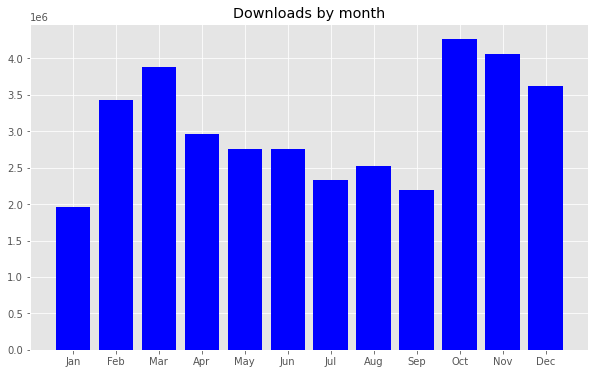

In [11]:
plt.rcParams["figure.figsize"] = (10, 6)

downloads = {
    'Jan': downloads_by_month.c[0],
    'Feb': downloads_by_month.c[1],
    'Mar': downloads_by_month.c[2],
    'Apr': downloads_by_month.c[3],
    'May': downloads_by_month.c[4],
    'Jun': downloads_by_month.c[5],
    'Jul': downloads_by_month.c[6],
    'Aug': downloads_by_month.c[7],
    'Sep': downloads_by_month.c[8],
    'Oct': downloads_by_month.c[9],
    'Nov': downloads_by_month.c[10],
    'Dec': downloads_by_month.c[11],
}

colors = ['blue'] * 12
plt.bar(range(len(downloads)), downloads.values(), color=colors)
plt.title('Downloads by month')
plt.xticks(range(len(downloads)), list(downloads.keys()))

plt.savefig('year-downloads-by-month.png')

plt.show()

In [12]:
df = pd.read_sql(f"""
    SELECT COUNT(*) AS searches_in_period
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
""", conn)

searches = df.values[0][0]
searches

222470704

In [13]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f USING (filename)
    JOIN builds b USING (build_id)
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,58024 days 19:57:59.802491


In [14]:
pd.read_sql(f"""
    SELECT SUM(filesize)
    FROM downloads
    JOIN files using (filename)
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,sum
0,50640689705559


In [15]:
top_30_downloads = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM downloads
    JOIN files USING (filename)
    JOIN builds USING (build_id)
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY package
    ORDER BY c DESC
    limit 30
""", conn)

top_30_downloads

,package,c
0,requests,684141
1,numpy,546668
2,setuptools,524595
3,pip,460168
4,idna,443288
5,urllib3,425864
6,chardet,420834
7,certifi,407524
8,websocket-client,404080
9,six,403825


In [16]:
print("<ol>")
for i, row in top_30_downloads.iterrows():
    print(f"<li><strong><a href='https://www.piwheels.org/project/{row['package']}'>{row['package']}</a></strong> ({row['c']:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (684,141)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (546,668)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (524,595)</li>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (460,168)</li>
<li><strong><a href='https://www.piwheels.org/project/idna'>idna</a></strong> (443,288)</li>
<li><strong><a href='https://www.piwheels.org/project/urllib3'>urllib3</a></strong> (425,864)</li>
<li><strong><a href='https://www.piwheels.org/project/chardet'>chardet</a></strong> (420,834)</li>
<li><strong><a href='https://www.piwheels.org/project/certifi'>certifi</a></strong> (407,524)</li>
<li><strong><a href='https://www.piwheels.org/project/websocket-client'>websocket-client</a></strong> (404,080)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (403,825)</li>
<li><

In [17]:
top_10_searches = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY package
    ORDER BY c desc
    LIMIT 10
""", conn)

top_10_searches

,package,c
0,pip,28919044
1,wheel,18932499
2,setuptools,11807471
3,pyrogram,4237340
4,future,3078697
5,pyngrok,2663116
6,youtube-dl,2565085
7,aiohttp,2361757
8,six,2219219
9,requests,2190259


In [18]:
print("<ol>")
for pkg, c in top_10_searches.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/pip'>pip</a></strong> (28,919,044)</li>
<li><strong><a href='https://www.piwheels.org/project/wheel'>wheel</a></strong> (18,932,499)</li>
<li><strong><a href='https://www.piwheels.org/project/setuptools'>setuptools</a></strong> (11,807,471)</li>
<li><strong><a href='https://www.piwheels.org/project/pyrogram'>pyrogram</a></strong> (4,237,340)</li>
<li><strong><a href='https://www.piwheels.org/project/future'>future</a></strong> (3,078,697)</li>
<li><strong><a href='https://www.piwheels.org/project/pyngrok'>pyngrok</a></strong> (2,663,116)</li>
<li><strong><a href='https://www.piwheels.org/project/youtube-dl'>youtube-dl</a></strong> (2,565,085)</li>
<li><strong><a href='https://www.piwheels.org/project/aiohttp'>aiohttp</a></strong> (2,361,757)</li>
<li><strong><a href='https://www.piwheels.org/project/six'>six</a></strong> (2,219,219)</li>
<li><strong><a href='https://www.piwheels.org/project/requests'>requests</a></strong> (2,19

In [19]:
top_10_project_pages = pd.read_sql(f"""
    SELECT package, COUNT(*) c
    FROM project_page_hits
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY package
    ORDER BY c desc
    LIMIT 10
""", conn)

top_10_project_pages

,package,c
0,opencv-python,5855
1,opencv-contrib-python,5200
2,numpy,4713
3,scipy,3206
4,tensorflow,2770
5,lilurl,2658
6,cryptography,2107
7,pillow,1774
8,pandas,1742
9,scikit-image,1673


In [20]:
print("<ol>")
for pkg, c in top_10_project_pages.values:
    print(f"<li><strong><a href='https://www.piwheels.org/project/{pkg}'>{pkg}</a></strong> ({c:,})</li>")
print("</ol>")

<ol>
<li><strong><a href='https://www.piwheels.org/project/opencv-python'>opencv-python</a></strong> (5,855)</li>
<li><strong><a href='https://www.piwheels.org/project/opencv-contrib-python'>opencv-contrib-python</a></strong> (5,200)</li>
<li><strong><a href='https://www.piwheels.org/project/numpy'>numpy</a></strong> (4,713)</li>
<li><strong><a href='https://www.piwheels.org/project/scipy'>scipy</a></strong> (3,206)</li>
<li><strong><a href='https://www.piwheels.org/project/tensorflow'>tensorflow</a></strong> (2,770)</li>
<li><strong><a href='https://www.piwheels.org/project/lilurl'>lilurl</a></strong> (2,658)</li>
<li><strong><a href='https://www.piwheels.org/project/cryptography'>cryptography</a></strong> (2,107)</li>
<li><strong><a href='https://www.piwheels.org/project/pillow'>pillow</a></strong> (1,774)</li>
<li><strong><a href='https://www.piwheels.org/project/pandas'>pandas</a></strong> (1,742)</li>
<li><strong><a href='https://www.piwheels.org/project/scikit-image'>scikit-image

In [ ]:
os_usage = pd.read_sql(f"""
    SELECT os_name, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY os_name
    ORDER BY c desc
""", conn)

os_usage

In [ ]:
os_usage.values[0][1] / searches

In [ ]:
distro_usage = pd.read_sql(f"""
    SELECT distro_name, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    GROUP BY distro_name
    ORDER BY c desc
    LIMIT 5
""", conn)

distro_usage

In [ ]:
distro_versions = pd.read_sql(f"""
    SELECT distro_version, count(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND distro_version in ('8', '9', '10', '11')
    GROUP BY distro_version
    ORDER BY c desc
""", conn)

distro_versions

In [ ]:
total = sum(distro_versions.c)

for v in distro_versions.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%')

In [ ]:
version_names = {'11': 'Bullseye', '10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(distro_versions.c, labels=[version_names[v] for v in distro_versions.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('year-debian-usage.png')

plt.show()

In [ ]:
arch = pd.read_sql(f"""
    SELECT arch, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY arch
    ORDER BY c desc
""", conn)

arch

In [ ]:
plt.pie(arch.c, labels=arch.arch)
plt.title('Architecture usage')

plt.savefig('year-arch.png')

plt.show()

In [ ]:
arm_arch = pd.read_sql(f"""
    SELECT arch, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND os_name = 'Linux'
    AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    AND arch in ('armv6l', 'armv7l', 'aarch64')
    GROUP BY arch
    ORDER BY c DESC
""", conn)

total = sum(arm_arch.c)

for v in arm_arch.values:
    print(v[0], f'{(100 * v[1] / total):.1f}%') 

In [ ]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('year-debian-arch.png')

plt.show()

In [ ]:
py_vers = pd.read_sql(f"""
    SELECT SUBSTRING(py_version from 1 for 3) pyver, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND py_name = 'CPython'
    GROUP BY pyver
    ORDER BY c desc
    LIMIT 5
""", conn)

py_vers

In [ ]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('year-py-vers.png')

plt.show()

In [ ]:
total = sum(row[1] for row in py_vers.values)

for ver, c in py_vers.values:
    print(ver, f'{100 * (c / total):.2f}%')

In [ ]:
pip_versions = pd.read_sql(f"""
    SELECT installer_version, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND installer_name = 'pip'
    AND installer_version is not null
    GROUP BY installer_version
    ORDER BY c DESC
""", conn)

pip_versions[:10]

In [ ]:
total = sum(v[1] for v in pip_versions.values)
labels = [v[0] if v[1] / total > 0.01 else '' for v in pip_versions.values]

plt.pie(pip_versions.c, labels=labels)
plt.title('pip version usage')

plt.savefig('year-pip-vers.png')

plt.show()

In [ ]:
setuptools_versions = pd.read_sql(f"""
    SELECT setuptools_version, COUNT(*) c
    FROM searches
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    AND installer_name = 'pip'
    AND setuptools_version IS NOT NULL
    GROUP BY setuptools_version
    ORDER BY c desc
""", conn)

setuptools_versions[:10]

In [ ]:
total = sum(v[1] for v in setuptools_versions.values)
labels = [v[0] if v[1] / total > 0.03 else '' for v in setuptools_versions.values]

plt.pie(setuptools_versions.c, labels=labels)
plt.title('setuptools version usage')

plt.savefig('year-setuptools-vers.png')

plt.show()

In [ ]:
downloads_by_hour = pd.read_sql(f"""
    SELECT date_part('hour', accessed_at) h, COUNT(*) c
    FROM downloads
    WHERE accessed_at BETWEEN '{start_time}' AND '{end_time}'
    GROUP BY h
    ORDER BY h
""", conn)

In [ ]:
list(downloads_by_hour['c'])

In [ ]:
hours = [int(h) for h in downloads_by_hour['h']]

plt.bar(range(len(downloads_by_hour)), list(downloads_by_hour['c']), color=['blue'] * 24)
plt.title('Downloads by hour')
plt.xticks(range(len(downloads_by_hour)), hours)

plt.savefig('year-downloads-by-hour.png')

plt.show()